# Visualizing Keywords Properties


In [12]:
import time
import multiprocessing as mp
from multiprocessing import Pool
from tqdm import tqdm
from tqdm.notebook import tqdm
import requests
import json
import re
import pandas as pd
import ast
import nltk
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

input_path = '../../wdr/Generating Adversarial Samples/Data/'
adv_samples_csv = ['ag-news_alzantot_distilbert.csv', 'imdb_bae_distilbert.csv', 'rotten-tomatoes_alzantot_distilbert.csv', 'ag-news_textfooler_distilbert.csv']

In [13]:
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

def count_pos_categories(words):
    tagged_words = pos_tag(word_tokenize(' '.join(words)))
    pos_counts = Counter(tag for word, tag in tagged_words)
    noun_count = sum(count for tag, count in pos_counts.items() if tag.startswith('NN'))
    verb_count = sum(count for tag, count in pos_counts.items() if tag.startswith('VB'))
    return {'Nonu': noun_count, 'Verb': verb_count}

def count_pos_all_categories(words):
    tagged_words = pos_tag(word_tokenize(' '.join(words)))
    pos_counts = Counter(tag for word, tag in tagged_words)
    
    pos_counts_dict = {
        'Noun': 0,
        'Verb': 0,
        'Adjective': 0,
        'Adverb': 0,
        'Pronoun': 0,
        'Determiner': 0,
        'Preposition': 0,
        'Conjunction': 0,
        'Interjection': 0,
        'Particle': 0,
        'To': 0,
        'Other': 0
    }
    
    for tag, count in pos_counts.items():
        if tag.startswith('NN'):
            pos_counts_dict['Noun'] += count
        elif tag.startswith('VB'):
            pos_counts_dict['Verb'] += count
        elif tag.startswith('JJ'):
            pos_counts_dict['Adjective'] += count
        elif tag.startswith('RB'):
            pos_counts_dict['Adverb'] += count
        elif tag.startswith('PR'):
            pos_counts_dict['Pronoun'] += count
        elif tag.startswith('DT'):
            pos_counts_dict['Determiner'] += count
        elif tag.startswith('IN'):
            pos_counts_dict['Preposition'] += count
        elif tag.startswith('CC'):
            pos_counts_dict['Conjunction'] += count
        elif tag.startswith('UH'):
            pos_counts_dict['Interjection'] += count
        elif tag.startswith('RP'):
            pos_counts_dict['Particle'] += count
        elif tag == 'TO':
            pos_counts_dict['To'] += count
        else:
            pos_counts_dict['Other'] += count
    
    return pos_counts_dict


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jing/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /Users/jing/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
results = []

for csv_file in adv_samples_csv:
    df = pd.read_csv(f'{input_path}{csv_file}', index_col=0)
    
    original_keywords = []
    replaced_keywords = []
    for raw_dict in df['replace_dict']:
        try:
            actual_dict = ast.literal_eval(raw_dict)
            original_keywords.extend(actual_dict.keys())
            replaced_keywords.extend(actual_dict.values())
        except ValueError as e:
            print(f"Error converting to dict: {e}")
    original_keywords_counter = Counter(original_keywords)
    replaced_keywords_counter = Counter(replaced_keywords)
    original_keywords_pos_counts = count_pos_all_categories(original_keywords)
    replaced_keywords_pos_counts = count_pos_all_categories(replaced_keywords)
    original_keywords_pos_columns = {f'original_keywords_{pos}': count for pos, count in original_keywords_pos_counts.items()}
    replaced_keywords_pos_columns = {f'replaced_keywords_{pos}': count for pos, count in replaced_keywords_pos_counts.items()}
    sum_pos_columns = {o[0]: o[1]+r[1] for o,r in zip(original_keywords_pos_counts.items(), replaced_keywords_pos_counts.items())}
    
    row = [csv_file, len(original_keywords_counter), len(replaced_keywords_counter)]
    row.extend(list(sum_pos_columns.values()))
    row.extend(list(original_keywords_pos_columns.values()))
    row.extend(list(replaced_keywords_pos_columns.values()))
    results.append(row)
columns = ['Setting', 'Unique_Keywords', 'Unique_Replaced_Keywords'] + list(sum_pos_columns.keys()) + list(original_keywords_pos_columns.keys()) + list(replaced_keywords_pos_columns.keys())
results_df = pd.DataFrame(results, columns=columns)
results_df.head()

,Setting,Unique_Keywords,Unique_Replaced_Keywords,Noun,Verb,Adjective,Adverb,Pronoun,Determiner,Preposition,...,replaced_keywords_Adjective,replaced_keywords_Adverb,replaced_keywords_Pronoun,replaced_keywords_Determiner,replaced_keywords_Preposition,replaced_keywords_Conjunction,replaced_keywords_Interjection,replaced_keywords_Particle,replaced_keywords_To,replaced_keywords_Other
0,ag-news_alzantot_distilbert.csv,931,977,1458,391,236,43,2,4,17,...,122,22,1,1,8,12,0,0,1,154
1,imdb_bae_distilbert.csv,2770,2292,4807,1938,2133,886,239,185,308,...,1119,402,92,92,158,48,10,11,2,933
2,rotten-tomatoes_alzantot_distilbert.csv,1009,1077,1056,591,710,363,1,7,40,...,338,182,1,5,15,5,0,0,1,6
3,ag-news_textfooler_distilbert.csv,3662,4667,8287,2097,1104,238,10,29,117,...,573,127,5,8,60,80,1,2,2,969


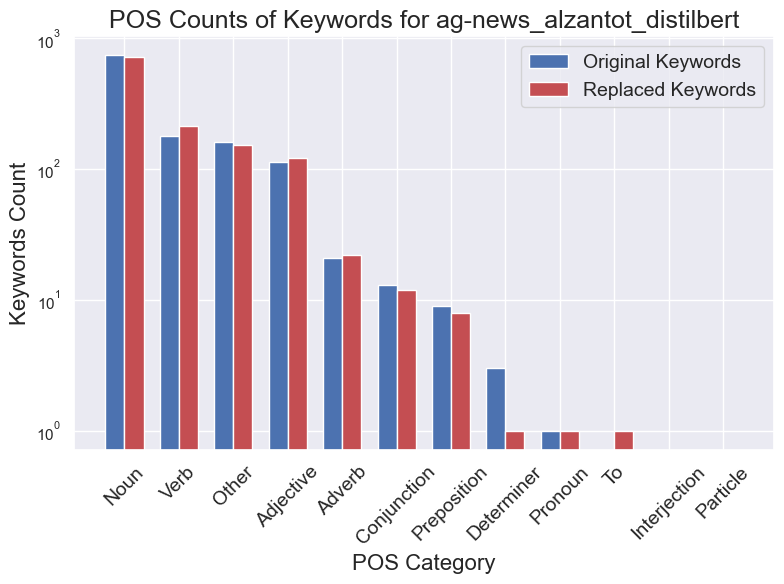

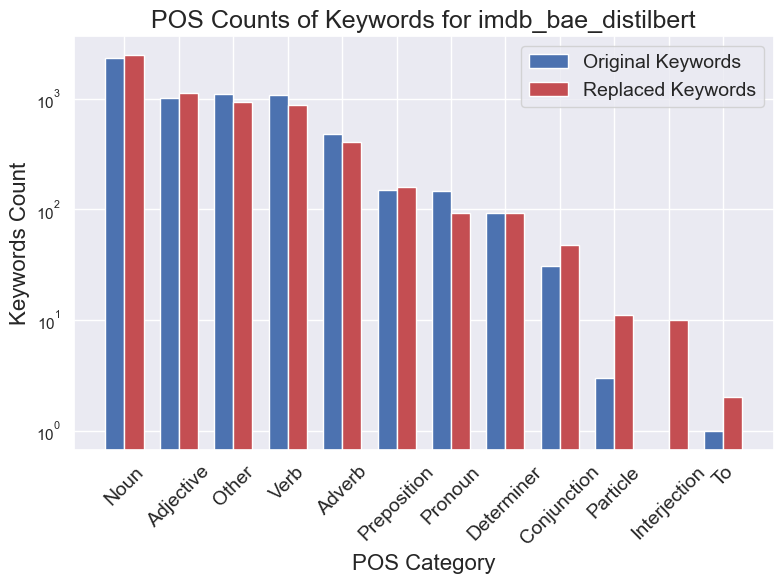

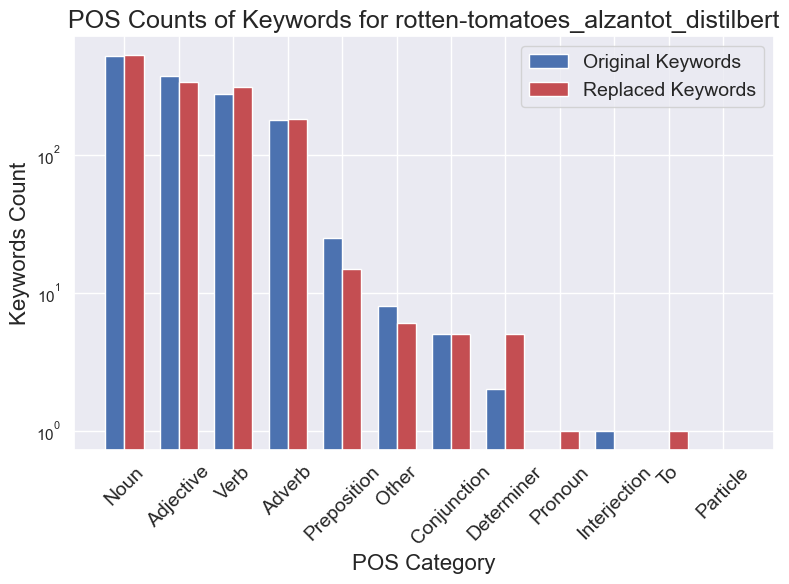

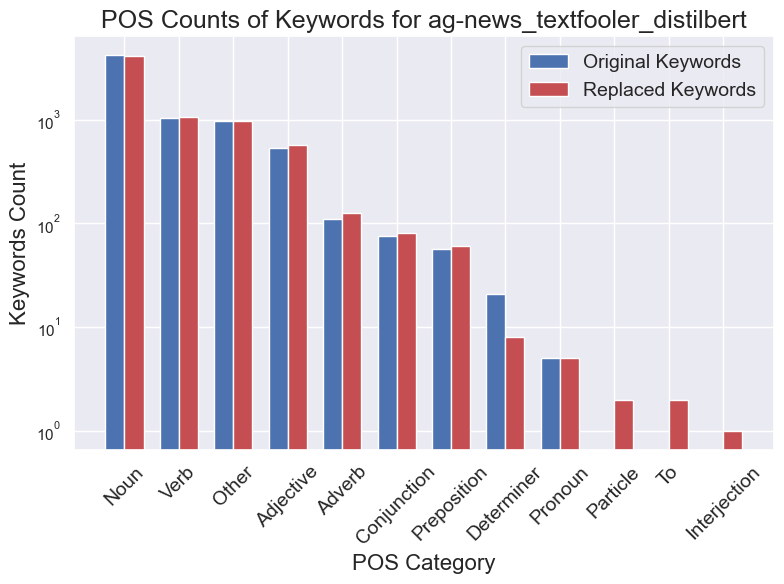

In [15]:
import numpy as np

for _, row in results_df.iterrows():
    sorted_pos = row[list(sum_pos_columns.keys())].sort_values(ascending=False)
    sorted_pos = sorted_pos.index.tolist()
    df = pd.DataFrame(index=['original_keywords', 'replaced_keywords'], columns=sorted_pos)
    for pos in sorted_pos:
        df.at['original_keywords', pos] = row[f'original_keywords_{pos}']
        df.at['replaced_keywords', pos] = row[f'replaced_keywords_{pos}']
    fig, ax = plt.subplots(figsize=(8, 6))
    bar_width = 0.35
    index = np.arange(len(sorted_pos))
    ax.bar(index, df.loc['original_keywords'], bar_width, label='Original Keywords', color='b')
    ax.bar(index + bar_width, df.loc['replaced_keywords'], bar_width, label='Replaced Keywords', color='r')
    setting = row["Setting"].strip('.csv')

    plt.title(f'POS Counts of Keywords for {setting}', fontsize=18)
    plt.xlabel('POS Category', fontsize=16)
    plt.ylabel('Count', fontsize=16)

    labels = [f'{pos}' for pos in sorted_pos]
    plt.xticks(index + bar_width / 2, labels, rotation=45, fontsize=14)
    plt.ylabel('Keywords Count', fontsize=16)
    plt.yscale('log')  
    plt.legend(fontsize=14)
    plt.tight_layout()
    plt.savefig(f'POS_for_{setting}.png', dpi=300) 
    plt.show()


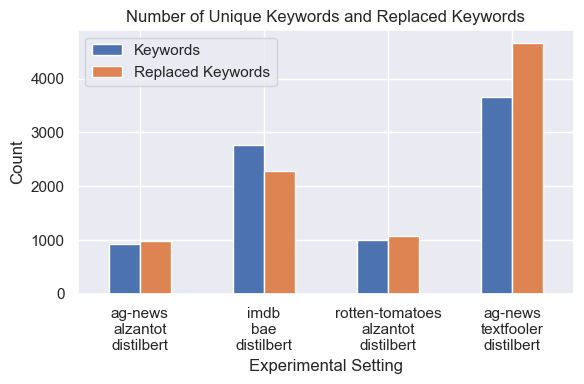

In [16]:
fig, ax = plt.subplots(figsize=(6, 4))
results_df['Setting'] = results_df['Setting'].apply(lambda x: '\n'.join(x.split('_')).strip('.csv'))
results_df.plot(x='Setting', y=['Unique_Keywords', 'Unique_Replaced_Keywords'], kind='bar', ax=ax, title='Number of Unique Keywords and Replaced Keywords')

ax.set_ylabel('Count')
ax.set_xlabel('Experimental Setting')
ax.legend(['Keywords', 'Replaced Keywords'])

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('Number_of_Unique_Keywords_original.png', dpi=300)  
plt.show()

